In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

This is based on the [homework of week 2](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week02.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The reference dataset is the [Kalahari !Kung San people](https://www.tensorflow.org/datasets/catalog/howell).

Loading the !Kung dataset

In [2]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


Taking a look at the range of ages of the dataset.

<AxesSubplot:xlabel='age'>

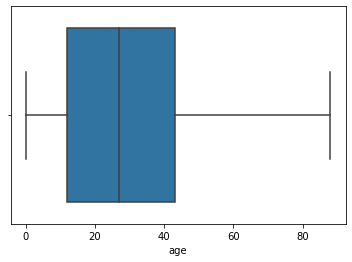

In [3]:
sns.boxplot(df['age'])

Creating a model.
As for the priors **a** is the height for when the weight is equal to the mean of weights.<br> 
As the dataset is composed mainly of teenagers and adults, I chose the mean of height as 150cm with a standard deviation of 20cm, which means that 95% of the heights are concentrated between 110cm and 190cm.   
<br>
Doing a simple regression we have the following:

In [4]:
x_bar = df['weight'].mean()

with pm.Model() as m_1:
    a = pm.Normal('a', 150, 20)
    bW = pm.Normal('bW', 0, 10)
    
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight']) - x_bar)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m1_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 3464.21draws/s]
The acceptance probability does not match the target. It is 0.6170758091792785, but should be close to 0.8. Try to increase the number of tuning steps.


In [5]:
varnames = ['~mu']
az.summary(m1_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,111.16,1.01,109.38,113.10
bW,1.76,0.03,1.71,1.81
sigma,9.31,0.28,8.77,9.84


In [6]:
mu_pred = m1_trace['mu']
mu_mean = mu_pred.mean(0)

Text(0, 0.5, 'height')

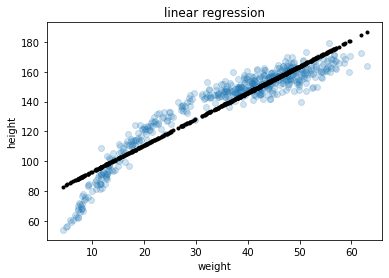

In [7]:
plt.scatter(df.weight, df.height, alpha=0.2)
plt.plot(df.weight, mu_mean, '.', color='black')# color='black')#, color='black', '.')
plt.title('linear regression')
plt.xlabel('weight')
plt.ylabel('height')

Not a good fit as we can see.

---

**Model the relationship between height(cm) and the natural logarithm of weight(log-kg)**

In [8]:
df['weight_log'] = np.log(df['weight'])
df.head()

,height,weight,age,male,weight_log
0,151.765,47.825606,63.0,1,3.867561
1,139.700,36.485807,63.0,0,3.596923
2,136.525,31.864838,65.0,0,3.461503
3,156.845,53.041915,41.0,1,3.971082
4,145.415,41.276872,51.0,0,3.720302


In [9]:
x_bar = df['weight_log'].mean()

with pm.Model() as m_2:
    a = pm.Normal('a', 150, 20)
    bW = pm.Lognormal('bW', 0, 5)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight_log'] - x_bar))
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m2_trace = pm.sample(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:03<00:00, 5454.72draws/s]


In [10]:
varnames = ["~mu"]
az.summary(m2_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,138.27,0.23,137.84,138.70
bW,47.08,0.38,46.37,47.82
sigma,5.13,0.16,4.86,5.45


In [11]:
mu_pred = m2_trace['mu']
mu_mean = mu_pred.mean(0)

Text(0, 0.5, 'height')

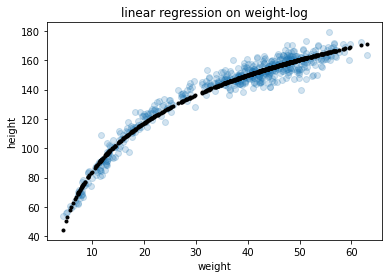

In [12]:
plt.scatter(df.weight, df.height, alpha=0.2)
plt.plot(df.weight, mu_mean, '.', color='black')
plt.title('linear regression on weight-log')
plt.xlabel('weight')
plt.ylabel('height')

---

**Polynomial regression model**

In [13]:
x_bar = df['weight'].mean()

with pm.Model() as m_3:
    a = pm.Normal('a', 150, 20)
    bW = pm.Lognormal('bW', 0, 5)
    cW = pm.Normal('cW', 0, 5)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight'] - x_bar) + cW*np.power((df['weight'] - x_bar),2))
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m3_trace = pm.sample(tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, cW, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:09<00:00, 2232.99draws/s]


In [14]:
varnames = ["~mu"]
az.summary(m3_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,146.67,0.38,145.95,147.36
cW,-0.04,0.00,-0.04,-0.04
bW,1.45,0.02,1.42,1.49
sigma,5.76,0.17,5.44,6.11


In [15]:
mu_pred = m3_trace['mu']
mu_mean = mu_pred.mean(0)

Text(0, 0.5, 'height')

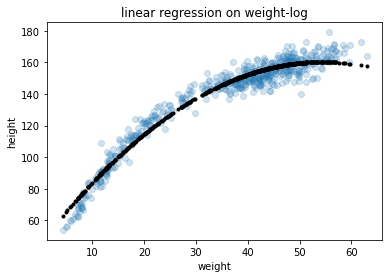

In [16]:
plt.scatter(df.weight, df.height, alpha=0.2)
plt.plot(df.weight, mu_mean, '.', color='black')
plt.title('linear regression on weight-log')
plt.xlabel('weight')
plt.ylabel('height')

In [17]:
with m_3:
    height_pred = pm.sample_posterior_predictive(trace=m3_trace, vars=[height], size=200)

100%|██████████| 2000/2000 [00:08<00:00, 246.68it/s]


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:153: UserWarning: More chains (2000) than draws (200). Passed array should have shape (chains, draws, *shape)
  UserWarning,


Text(0, 0.5, 'height')

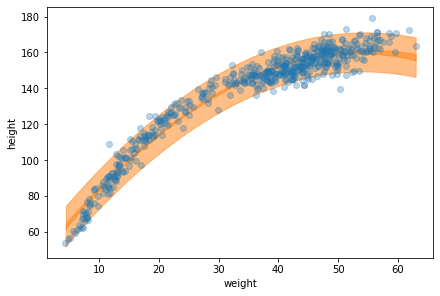

In [18]:
ax = az.plot_hdi(df.weight, mu_pred, hdi_prob=0.89)
az.plot_hdi(df.weight, height_pred['height'], ax=ax)
plt.scatter(df.weight, df.height, alpha=0.3)
#plt.plot(df.weight_log, mu_mean, color='black')# color='black')#, color='black', '.')
plt.xlabel('weight')
plt.ylabel('height')

---

**Making some predictions of height and 89% interval, with the model, for the table below.**

Table to be filled with predictions

In [20]:
df_pred = pd.DataFrame({'individual':[1 , 2, 3, 4, 5],
                        'weight':[45, 40, 65, 31, 53],
                        'exp_height':[0, 0, 0, 0, 0],
                        'interval_89':['', '', '', '', '']})
df_pred

,individual,weight,exp_height,interval_89
0,1,45,0,
1,2,40,0,
2,3,65,0,
3,4,31,0,
4,5,53,0,


Below we fill the table with the predictions for expected height and the 89% interval.

In [28]:
for i in range(df_pred.shape[0]):
    # expected height
    exp_height = m3_trace['a'] + m3_trace['bW']*df_pred['weight'][i]-df.weight.mean() + \
                    m3_trace['cW']*np.power(df_pred['weight'][i]-df.weight.mean(), 2) 
    
    df_pred.loc[i, 'exp_height'] = exp_height.mean()
    
    # 89% interval
    df_pred.loc[i, 'interval_89'] = str(az.hdi(exp_height, hdi_prob=.89))

In [29]:
df_pred

,individual,weight,exp_height,interval_89
0,1,45,173.097842,[171.71586733 174.40934188]
1,2,40,168.496467,[167.36183055 169.66732749]
2,3,65,172.109293,[169.30741384 175.40565684]
3,4,31,155.326694,[154.45674611 156.2975248 ]
4,5,53,176.426079,[174.59112752 178.18848811]
